# Distracted driver detection

According to the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. Sadly, this translates to 425,000 people injured and 3,000 people killed by distracted driving every year.



In [1]:
# Importing necessary functions and libraries
from datetime import date
import typing as t
import warnings
import os
import pathlib
import random
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import (
    models,
    layers,
    applications,
    preprocessing,
    optimizers,
    callbacks,
)
from mlxtend import plotting
from tqdm.auto import tqdm

warnings.simplefilter("ignore")

In [22]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, classification_report, accuracy_score

In [2]:
# Creating utility helper functions
def show_random_samples(
    directory_path: t.Union[pathlib.Path, str], label: str, num_of_samples: int = 5
) -> None:
    """
    Shows sample of images from a directory belonging to a class

    Args:
        directory_path (t.Union[pathlib.Path, str]): Path of the parent directory where `label` is located
        label (str): Class label of the image
        num_of_samples (int, optional): Number of samples to show. Defaults to 5.
    """
    files = os.listdir(os.path.join(directory_path, label))
    plt.figure(figsize=(10, 12))
    plt.subplots_adjust(wspace=2)
    for i in range(num_of_samples):
        plt.subplot(1, num_of_samples, i + 1)
        sample = random.choice(files)
        sample_path = os.path.join(os.path.join(directory_path, label), sample)
        img = mpimg.imread(sample_path)
        imgplot = plt.imshow(img)
        plt.axis(False)
        plt.title(f"{label.lower().capitalize()}\n{img.shape}")
    plt.show()


def create_class_weight(label_count_dict: t.Dict[str, int]) -> t.Dict[int, float]:
    """
    Creates class weights, optimally used for imbalanced data

    Args:
        label_count_dict (t.Dict[str, int]): Dictionary in the format {`label` : `count`}

    Returns:
        t.Dict[int, float]: Class weights dictionary in the format {`label` : `weight`}
    """
    total_samples = np.sum(list(label_count_dict.values()))
    labels = label_count_dict.keys()
    class_weights = dict()

    for idx, label in enumerate(labels):
        class_weights[idx] = float(
            total_samples / (len(list(labels)) * label_count_dict[label])
        )

    return class_weights


def create_model_checkpoint(
    model_name: str, directory: str = "models/"
) -> tf.keras.callbacks.ModelCheckpoint:
    """
    Returns a model checkpoint callback to save the best model while training.

    Args:
        model_name (str): Name of the model, functions creates a directory for the model of this name
        save_path (str, optional): Main directory to store all weights. Defaults to "model_experiments".

    Returns:
        tf.keras.callbacks.ModelCheckpoint: A callback to get the best model configuration according to the training.
    """
    directory = pathlib.Path(directory)
    directory.mkdir(parents=True, exist_ok=True)
    filepath = directory / f"{model_name}.h5"
    return callbacks.ModelCheckpoint(
        filepath=filepath, verbose=1, save_best_only=True, save_weights_only=False
    )


def create_early_stopping(
    patience: int = 3, restore_best_weights: bool = True
) -> tf.keras.callbacks.EarlyStopping:
    """
    Returns a early stopping callback

    Args:
        patience (int, optional): Number of iterations to look for improvement. Defaults to 3.
        restore_best_weights (bool, optional): Restore best weights. Defaults to True.

    Returns:
        tf.keras.callbacks.EarlyStoppin: A callback to stop training if the validation loss does not decrease.
    """
    return callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=restore_best_weights,
    )


def plot_loss_curves(history: tf.keras.callbacks.History) -> None:
    """
    Shows separate loss curves for training and validation metrics.

    Args:
        history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.figure(figsize=(19, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.xticks(epochs)
    plt.legend(loc="upper right")

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.xticks(epochs)
    plt.legend(loc="upper left")


def plot_conf_matrix(
    y_true: npt.ArrayLike, y_pred: npt.ArrayLike, classes: list
) -> None:
    """
    Plots confusion matrix

    Args:
        y_true (npt.ArrayLike): True labels
        y_pred (npt.ArrayLike): Pred labels
        classes (list): List with names of classes
    """
    cnf_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    plotting.plot_confusion_matrix(
        conf_mat=cnf_matrix, class_names=classes, figsize=(10, 7)
    )


def get_metrics(
    y_true: npt.ArrayLike,
    y_pred: npt.ArrayLike,
    model_path: pathlib.Path,
    classes: list,
    plot_confusion_matrix: bool = False,
) -> t.Dict[str, float]:
    """
    Generates classification metrics, optionally shows confusion matrix

    Args:
        y_true (npt.ArrayLike): True labels, make sure the arrays are flattened!
        y_pred (npt.ArrayLike): Predicted labels, make sure the arrays are flattened!
        plot_confusion_matrix (bool, optional): Shows confusion matrix. Defaults to False.

    Raises:
        ValueError: When shape of `y_test` and `y_pred` are not the same.

    Returns:
        t.Dict[str, float]: Classification metrics
    """
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch error!")

    y_true, y_pred = y_true.flatten(), y_pred.flatten()

    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred, average="micro")
    recall = metrics.recall_score(y_true, y_pred, average="micro")
    f1_score = metrics.f1_score(y_true, y_pred, average="micro")

    if plot_confusion_matrix:
        plot_conf_matrix(y_true, y_pred, classes=classes)

    # Model file size in MBs
    model_size = model_path.stat().st_size // (1024**2)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1_score,
        "Size (MB)": model_size,
    }


def load_and_prep_image(filename: pathlib.Path, img_shape: int = 224):
    """
    Returns an image tensor by reading the image on `filepath`

    Args:
        filename (pathlib.Path): Filepath of a single image
        img_shape (int, optional): Image dimension. This is considered as both height and width of image for resizing. Defaults to 224.

    Returns:
        tf.Tensor: Image as a tensor
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    return img


In [3]:
# Defining config variables
class CONFIG:
    train_path = pathlib.Path(
        "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"
    )
    test_path = pathlib.Path(
        "/kaggle/input/state-farm-distracted-driver-detection/imgs/test"
    )
    classes = [
        "c0",
        "c1",
        "c2",
        "c3",
        "c4",
        "c5",
        "c6",
        "c7",
        "c8",
        "c9",
    ]
    num_classes = len(classes)
    image_size = 224
    verbose = 1
    batch_size = 32
    autotune = tf.data.AUTOTUNE
    seed = 42
    

## Data Preprocessing

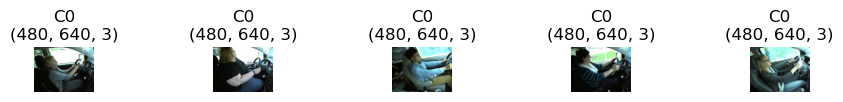

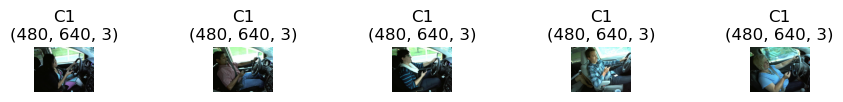

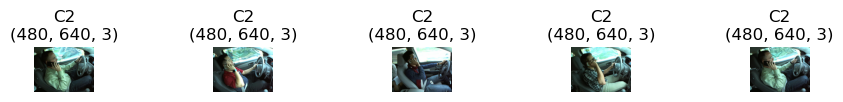

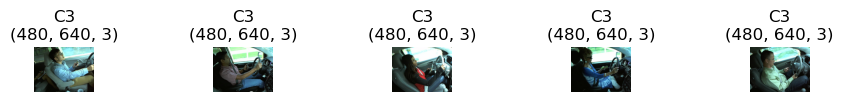

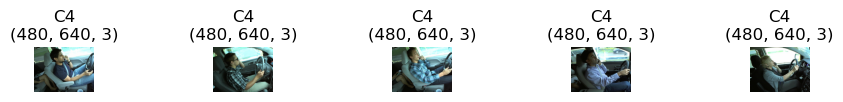

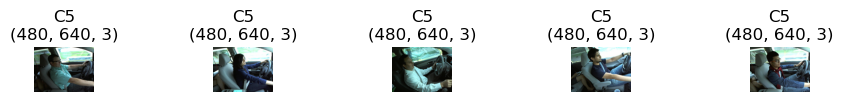

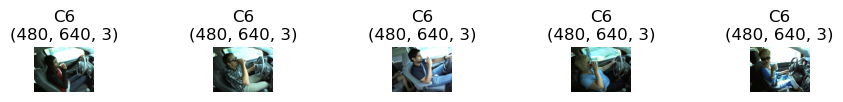

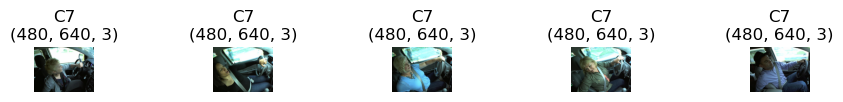

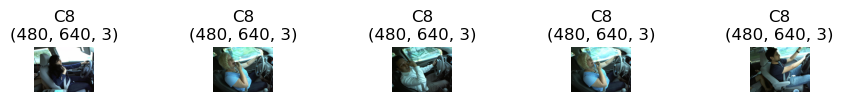

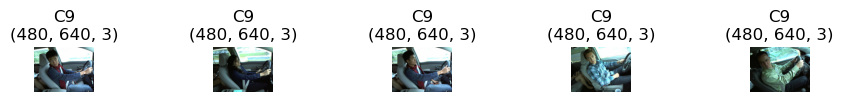

In [4]:
# Display random example of data
for idx, label in enumerate(CONFIG.classes):
    show_random_samples(CONFIG.train_path, label)

Image size: (480, 640, 3)
Maximum pixel value in the image: 255


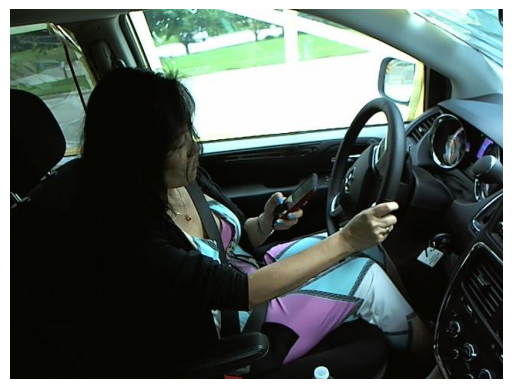

In [5]:
# Displaying a sample from image to get the statistics
image = mpimg.imread(
    "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c3/img_100006.jpg"
)
print(f"Image size: {image.shape}")
print(f"Maximum pixel value in the image: {tf.math.reduce_max(image)}")
plt.imshow(image)
plt.axis(False)
plt.show()

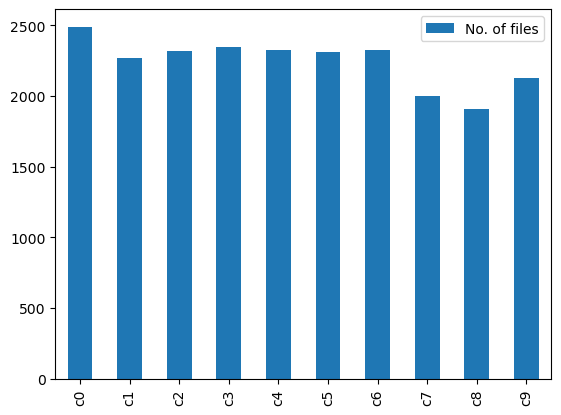

In [6]:
# Get the statistics about the data
data_count_dict = {}
for label in CONFIG.classes:
    data_count = len(os.listdir(os.path.join(CONFIG.train_path, label)))
    data_count_dict[label] = data_count

data_count_df = pd.DataFrame.from_dict(data_count_dict, orient="index").rename(
    columns={0: "No. of files"}
)
data_count_df.plot(kind="bar");

In [7]:
# To make data processing faster
datagen = preprocessing.image.ImageDataGenerator(
    zoom_range=0.2, rotation_range=20, horizontal_flip=True, validation_split=0.15
)

train_ds = datagen.flow_from_directory(
    directory=CONFIG.train_path,
    target_size=(CONFIG.image_size, CONFIG.image_size),
    batch_size=CONFIG.batch_size,
    class_mode="sparse",
    seed=CONFIG.seed,
    subset="training",
)

val_ds = datagen.flow_from_directory(
    directory=CONFIG.train_path,
    target_size=(CONFIG.image_size, CONFIG.image_size),
    batch_size=CONFIG.batch_size,
    class_mode="sparse",
    seed=CONFIG.seed,
    subset="validation",
    shuffle=False,
)

test_dataloader = tf.data.Dataset.list_files(str(CONFIG.test_path / "*.jpg"), shuffle=False)
test_dataloader = (
    test_dataloader.map(
        lambda x: load_and_prep_image(x, CONFIG.image_size),
        num_parallel_calls=CONFIG.autotune,
    )
    .batch(CONFIG.batch_size)
    .prefetch(1)
)

test_filepaths = []
for filepath in test_dataloader.list_files(str(CONFIG.test_path / "*.jpg"), shuffle=False):
    test_filepaths.append(filepath.numpy().decode("UTF-8"))

y_val_labels = val_ds.classes
class_indices = dict(map(reversed, val_ds.class_indices.items()))
print(f"[INFO] Data loaders and artifacts processed")

Found 19066 images belonging to 10 classes.
Found 3358 images belonging to 10 classes.
[INFO] Data loaders and artifacts processed


## Step 3: Describe modelling experiments

#### Process to follow when making models:
0. Set random seeds
1. Create the model architecture
2. Compile the model by defining loss function and optimizer
3. Train the model with validation split of 15%, and add appropriate callbacks
4. Plot the loss curves
5. Load in the best weights
6. Evaluate performance on whole validation data
7. Get metrics for training data


#### Models to be made:
- Model 1: Fine-tuned **ResNet50**, validated on 15% training data
- Model 2: Fine-tuned **VGG16**, validated on 15% training data
- Model 3: Fine-tuned **VGG19** validated on 15% training data
- Model 4: Fine-tuned **EfficientNetB3**, validated on 15% training data


### Model 1
***Architecture***: Fine-tuned ResNet50  
***Optimizer***: Adam optimizer with 0.0001 learning rate  
***Epochs*** : 10  
***Callbacks*** : Early stopping, Model checkpointing

In [25]:
# 0. Set random seed
tf.random.set_seed(CONFIG.seed)
INPUT_SHAPE = (CONFIG.image_size, CONFIG.image_size, 3)

# 1. Create the model
base_resnet_model = applications.resnet50.ResNet50(
    include_top=False, weights="imagenet"
)
base_resnet_model.trainable = False

LAYERS_TRAINALBLE = 10
for layer in base_resnet_model.layers[-LAYERS_TRAINALBLE:]:
    layer.trainable = True

model_1 = tf.keras.Sequential(
    [
        layers.Input(shape=INPUT_SHAPE),
        base_resnet_model,
        layers.GlobalAveragePooling2D(name="global_average_pooling_layer"),
        layers.Dense(1024, activation="relu", name="fcl1"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu", name="fcl2"),
        layers.Dropout(0.2),
        layers.Dense(CONFIG.num_classes, activation="softmax", name="output"),
    ],
    name="model_1_resnet_ft",
)

# 2. Compile the model
LEARNING_RATE = 1e-3
optim = optimizers.Adam(learning_rate=LEARNING_RATE)
model_1.compile(
    loss="sparse_categorical_crossentropy", optimizer=optim, metrics=["accuracy"]
)

# 3. Fit the model
history_model_1 = model_1.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    verbose=CONFIG.verbose,
    callbacks=[
        create_model_checkpoint(model_name=model_1.name),
        create_early_stopping(patience=3),
    ],
)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
596/596 [==============================] - ETA: 0s - loss: 1.3669 - accuracy: 0.5140
Epoch 1: val_loss improved from inf to 0.69602, saving model to models/model_1_resnet_ft.h5
596/596 [==============================] - 365s 603ms/step - loss: 1.3669 - accuracy: 0.5140 - val_loss: 0.6960 - val_accuracy: 0.7725
Epoch 2/10
596/596 [==============================] - ETA: 0s - loss: 0.7122 - accuracy: 0.7530
Epoch 2: val_loss improved from 0.69602 to 0.52566, saving model to models/model_1_resnet_ft.h5
596/596 [==============================] - 336s 564ms/step - loss: 0.7122 - accuracy: 0.7530 - val_loss: 0.5257 - val_accuracy: 0.8258
Epoch 3/10
596/596 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.8031
Epoch 3: val_loss improved from 0.52566 to 0.39127, saving model to models/model_1_resnet_ft.h5
596/596 [==============================] - 346s 580ms/step - loss: 0.5621 - accuracy: 0.8031 

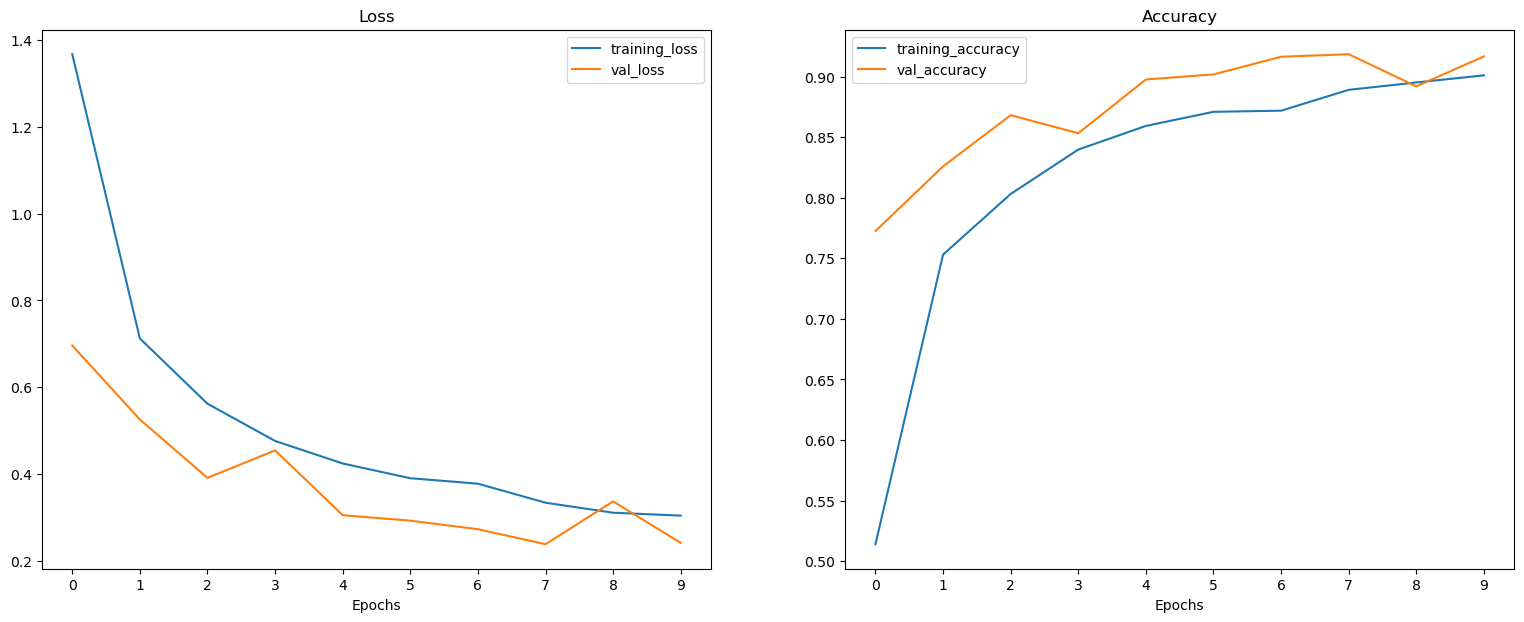

In [26]:
# 4. Plot model training performance
plot_loss_curves(history_model_1)

In [27]:
# 5. Loading the best weights
best_weights_path_model_1 = "/kaggle/working/models/model_1_resnet_ft.h5"
model_1 = models.load_model(best_weights_path_model_1)

In [28]:
# 6. Evaluate on test data
model_1.evaluate(val_ds)

105/105 [==============================] - 52s 484ms/step - loss: 0.2289 - accuracy: 0.9297


[0.22886155545711517, 0.9297200441360474]

105/105 [==============================] - 50s 464ms/step


{'Accuracy': 0.9258487194758785,
 'Precision': 0.9258487194758785,
 'Recall': 0.9258487194758785,
 'F1-score': 0.9258487194758785,
 'Size (MB)': 117}

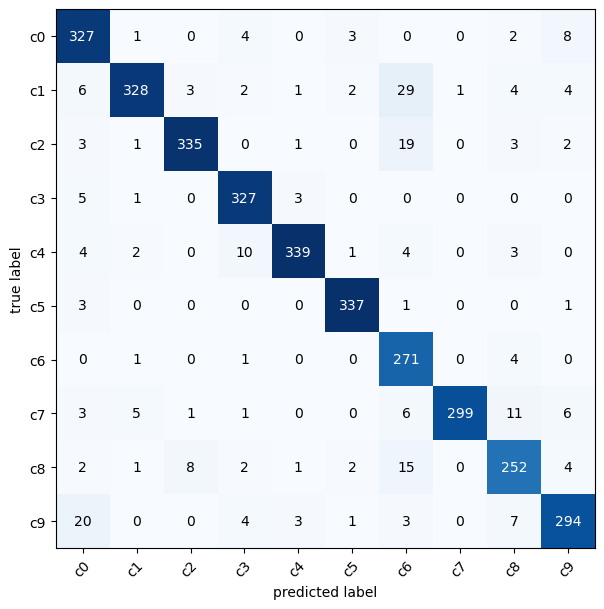

In [29]:
# 7. Get the model's performance metrics
model_1_pred_probs = model_1.predict(val_ds, verbose=1)
model_1_pred_classes = model_1_pred_probs.argmax(axis=1).reshape(-1).astype("int")

model_1_metrics = get_metrics(
    y_true=model_1_pred_classes,
    y_pred=y_val_labels,
    model_path=pathlib.Path(best_weights_path_model_1),
    plot_confusion_matrix=True,
    classes=CONFIG.classes,
)
model_1_metrics

In [31]:
#Recall per class
recall_per_class2 = []
for i in range(10):
    recall2 = recall_score(y_val_labels, model_1_pred_classes, labels=[i], average='weighted')

    recall_per_class2.append(recall2)

# Print recall for each class
for i, recall2 in enumerate(recall_per_class2):
    print(f"Recall for class {i}: {recall2}")

Recall for class 0: 0.8766756032171582
Recall for class 1: 0.9647058823529412
Recall for class 2: 0.9654178674351584
Recall for class 3: 0.9316239316239316
Recall for class 4: 0.9741379310344828
Recall for class 5: 0.9739884393063584
Recall for class 6: 0.7787356321839081
Recall for class 7: 0.9966666666666667
Recall for class 8: 0.8811188811188811
Recall for class 9: 0.9216300940438872


### Model 2
***Architecture***: Fine-tuned VGG16  
***Optimizer***: Adam optimizer with 0.0001 learning rate  
***Epochs*** : 7  
***Callbacks*** : Early stopping, Model checkpointing  

In [8]:
# 0. Set random seed
tf.random.set_seed(CONFIG.seed)
INPUT_SHAPE = (CONFIG.image_size, CONFIG.image_size, 3)

# 1. Create the model
base_vgg_model = applications.VGG16(include_top=False, weights="imagenet")
base_vgg_model.trainable = False

LAYERS_TRAINALBLE = 10
for layer in base_vgg_model.layers[-LAYERS_TRAINALBLE:]:
    layer.trainable = True

model_2 = tf.keras.Sequential(
    [
        layers.Input(shape=INPUT_SHAPE),
        base_vgg_model,
        layers.GlobalAveragePooling2D(name="global_average_pooling_layer"),
        layers.Dense(1024, activation="relu", name="fcl1"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu", name="fcl2"),
        layers.Dropout(0.2),
        layers.Dense(CONFIG.num_classes, activation="softmax", name="output"),
    ],
    name="model_2_vgg_ft",
)

# 2. Compile the model
LEARNING_RATE = 1e-3
optim = optimizers.Adam(learning_rate=LEARNING_RATE)
model_2.compile(
    loss="sparse_categorical_crossentropy", optimizer=optim, metrics=["accuracy"]
)

# 3. Fit the model
history_model_2 = model_2.fit(
    train_ds,
    epochs=7,
    validation_data=val_ds,
    verbose=CONFIG.verbose,
    callbacks=[
        create_model_checkpoint(model_name=model_2.name),
        create_early_stopping(patience=3),
    ],
)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/7
596/596 [==============================] - ETA: 0s - loss: 1.8547 - accuracy: 0.3527
Epoch 1: val_loss improved from inf to 1.05464, saving model to models/model_2_vgg_ft.h5
596/596 [==============================] - 483s 785ms/step - loss: 1.8547 - accuracy: 0.3527 - val_loss: 1.0546 - val_accuracy: 0.6712
Epoch 2/7
596/596 [==============================] - ETA: 0s - loss: 0.9874 - accuracy: 0.6581
Epoch 2: val_loss improved from 1.05464 to 0.66551, saving model to models/model_2_vgg_ft.h5
596/596 [==============================] - 355s 596ms/step - loss: 0.9874 - accuracy: 0.6581 - val_loss: 0.6655 - val_accuracy: 0.7808
Epoch 3/7
596/596 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.7545
Epoch 3: val_loss improved from 0.66551 to 0.53136, saving model to models/model_2_vgg_ft.h5
596/596 [==============================] - 348s 584ms/step - loss: 0.7277 - accuracy: 0.7545 - val_loss: 

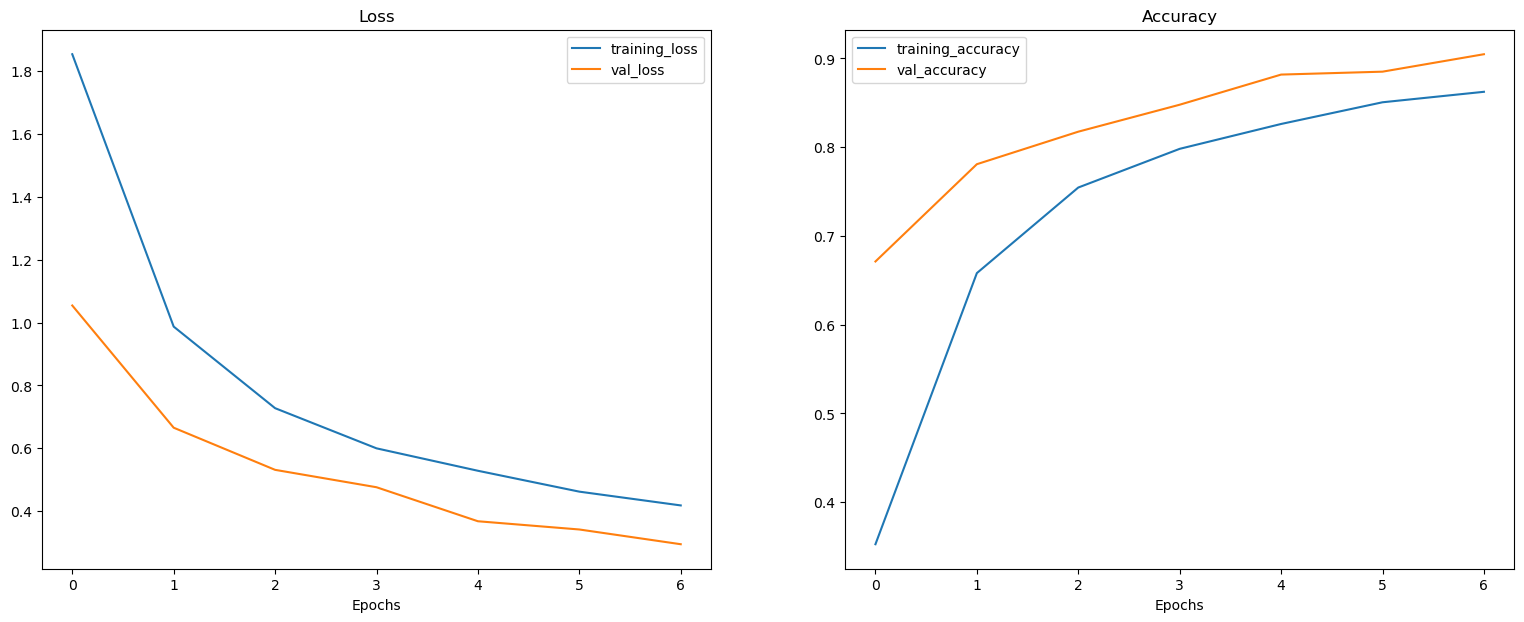

In [9]:
# 4. Plot model training performance
plot_loss_curves(history_model_2)

In [10]:
# 5. Loading the best weights
best_weights_path_model_2 = "/kaggle/working/models/model_2_vgg_ft.h5"
model_2 = models.load_model(best_weights_path_model_2)

In [11]:
# 6. Evaluate on test data
model_2.evaluate(val_ds)

105/105 [==============================] - 52s 490ms/step - loss: 0.3227 - accuracy: 0.8976


[0.32271450757980347, 0.8975580930709839]

105/105 [==============================] - 50s 474ms/step


{'Accuracy': 0.9038117927337701,
 'Precision': 0.9038117927337701,
 'Recall': 0.9038117927337701,
 'F1-score': 0.9038117927337701,
 'Size (MB)': 65}

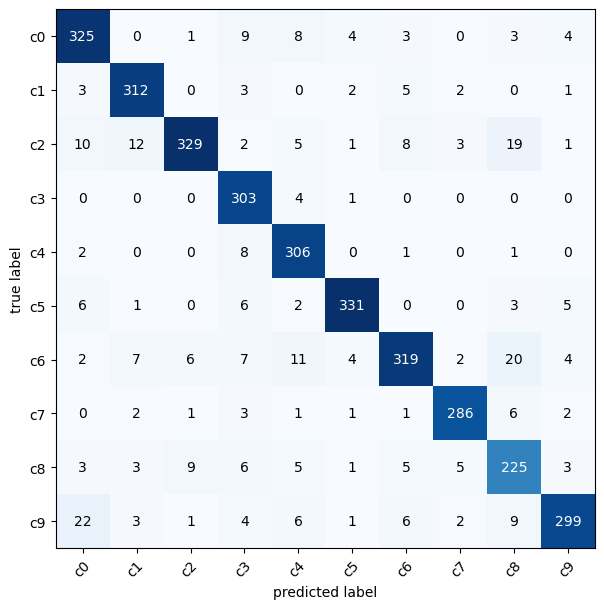

In [12]:
# 7. Get the model's performance metrics
model_2_pred_probs = model_2.predict(val_ds, verbose=1)
model_2_pred_classes = model_2_pred_probs.argmax(axis=1).reshape(-1).astype("int")

model_2_metrics = get_metrics(
    y_true=model_2_pred_classes,
    y_pred=y_val_labels,
    model_path=pathlib.Path(best_weights_path_model_2),
    plot_confusion_matrix=True,
    classes=CONFIG.classes,
)
model_2_metrics

In [32]:
#Recall per class
recall_per_class2 = []
for i in range(10):
    recall2 = recall_score(y_val_labels, model_2_pred_classes, labels=[i], average='weighted')

    recall_per_class2.append(recall2)

# Print recall for each class
for i, recall2 in enumerate(recall_per_class2):
    print(f"Recall for class {i}: {recall2}")

Recall for class 0: 0.871313672922252
Recall for class 1: 0.9176470588235294
Recall for class 2: 0.9481268011527377
Recall for class 3: 0.8632478632478633
Recall for class 4: 0.8793103448275862
Recall for class 5: 0.9566473988439307
Recall for class 6: 0.9166666666666666
Recall for class 7: 0.9533333333333334
Recall for class 8: 0.7867132867132867
Recall for class 9: 0.9373040752351097


### Model 3
***Architecture***: VGG 19          
***Optimizer***: Adam optimizer with 0.001 learning rate  
***Epochs*** : 50  
***Callbacks*** : Early stopping, Model checkpointing  

In [13]:
# 0. Set random seed
tf.random.set_seed(CONFIG.seed)
INPUT_SHAPE = (CONFIG.image_size, CONFIG.image_size, 3)

base_vgg19_model = applications.VGG19(include_top=False, weights="imagenet")
base_vgg19_model.trainable = False

LAYERS_TRAINALBLE = 10
for layer in base_vgg19_model.layers[-LAYERS_TRAINALBLE:]:
    layer.trainable = True

model_3 = tf.keras.Sequential(
    [
        layers.Input(shape=INPUT_SHAPE),
        base_vgg19_model,
        layers.GlobalAveragePooling2D(name="global_average_pooling_layer"),
        layers.Dense(2048,activation='relu', name="fcl1"),
        layers.Dense(1024, activation="relu", name="fcl2"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu", name="fcl3"),
        layers.Dropout(0.2),
        layers.Dense(CONFIG.num_classes, activation="softmax", name="output"),
    ],
    name="model_3_vgg_ft",
)

# 2. Compile the model
LEARNING_RATE = 1e-3
optim = optimizers.Adam(learning_rate=LEARNING_RATE)
model_3.compile(
    loss="sparse_categorical_crossentropy", optimizer=optim, metrics=["accuracy"]
)

# 3. Fit the model
history_model_3 = model_3.fit(
    train_ds,
    epochs=7,
    validation_data=val_ds,
    verbose=CONFIG.verbose,
    callbacks=[
        create_model_checkpoint(model_name=model_3.name),
        create_early_stopping(patience=3),
    ],
)


80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/7
596/596 [==============================] - ETA: 0s - loss: 1.5321 - accuracy: 0.4669
Epoch 1: val_loss improved from inf to 0.78378, saving model to models/model_3_vgg_ft.h5
596/596 [==============================] - 361s 602ms/step - loss: 1.5321 - accuracy: 0.4669 - val_loss: 0.7838 - val_accuracy: 0.7385
Epoch 2/7
596/596 [==============================] - ETA: 0s - loss: 0.7608 - accuracy: 0.7430
Epoch 2: val_loss improved from 0.78378 to 0.64343, saving model to models/model_3_vgg_ft.h5
596/596 [==============================] - 343s 575ms/step - loss: 0.7608 - accuracy: 0.7430 - val_loss: 0.6434 - val_accuracy: 0.7814
Epoch 3/7
596/596 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.8256
Epoch 3: val_loss improved from 0.64343 to 0.47924, saving model to models/model_3_vgg_ft.h5
596/596 [==============================] - 345s 579ms/step - loss: 0.5311 - accuracy: 0.8256 - val_loss: 

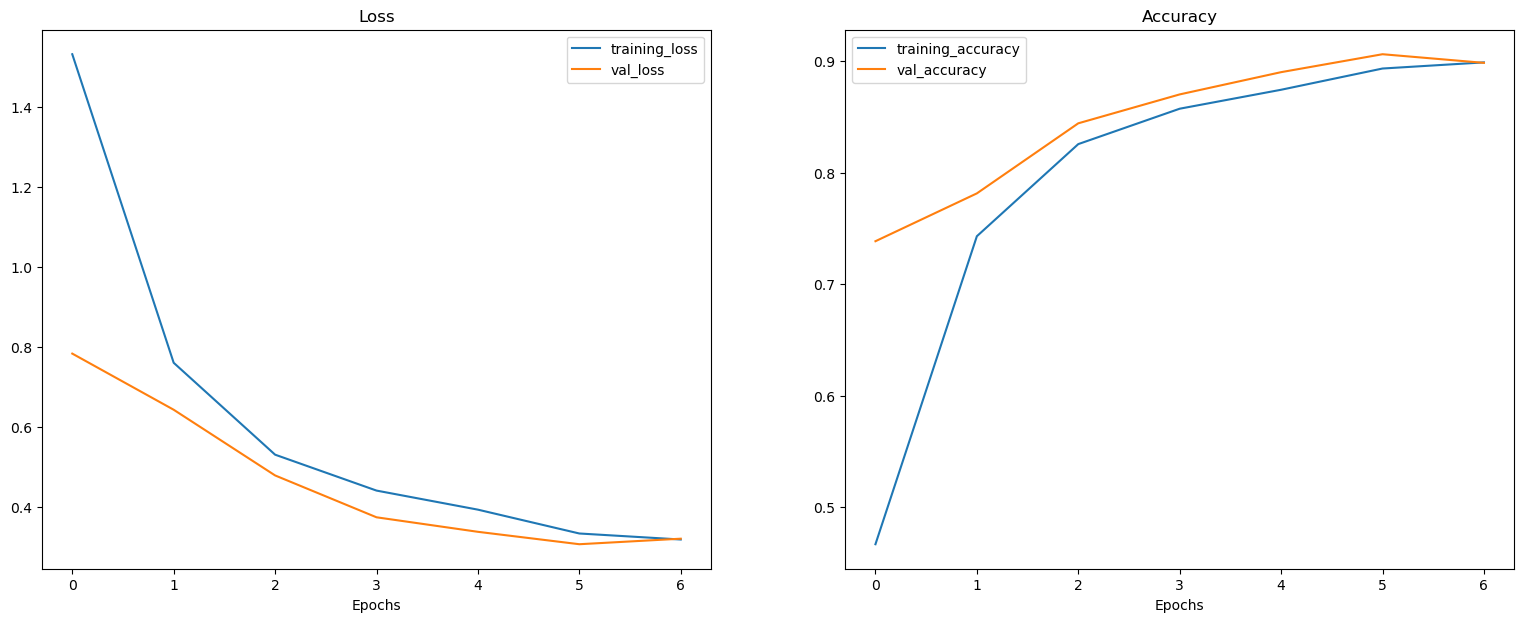

In [14]:
# 4. Plot model training performance
plot_loss_curves(history_model_3)

In [16]:
# 5. Loading the best weights
best_weights_path_model_3 = "/kaggle/working/models/model_3_vgg_ft.h5"
model_3 = models.load_model(best_weights_path_model_3)

In [17]:
# 6. Evaluate on test data
model_3.evaluate(val_ds)

105/105 [==============================] - 53s 504ms/step - loss: 0.3204 - accuracy: 0.9008


[0.3203512728214264, 0.9008338451385498]

105/105 [==============================] - 50s 479ms/step


{'Accuracy': 0.8966646813579512,
 'Precision': 0.8966646813579512,
 'Recall': 0.8966646813579512,
 'F1-score': 0.8966646813579512,
 'Size (MB)': 115}

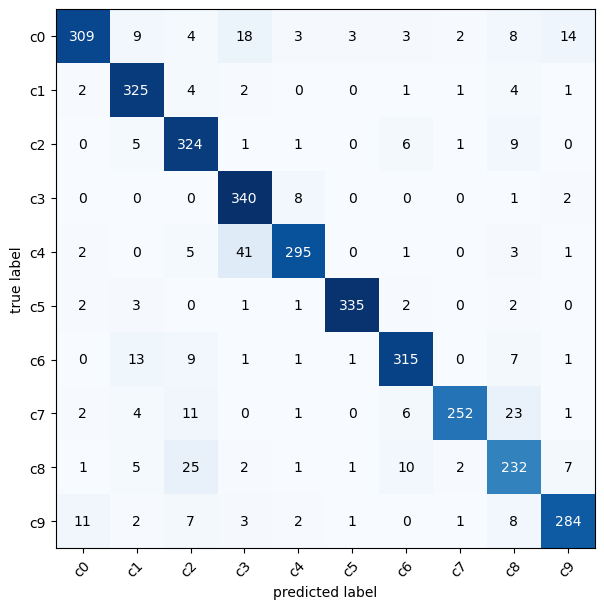

In [19]:
# 7. Get the model's performance metrics
model_3_pred_probs = model_3.predict(val_ds, verbose=1)
model_3_pred_classes = model_3_pred_probs.argmax(axis=1).reshape(-1).astype("int")

model_3_metrics = get_metrics(
    y_true=y_val_labels,
    y_pred=model_3_pred_classes,
    model_path=pathlib.Path(best_weights_path_model_3),
    plot_confusion_matrix=True,
    classes=CONFIG.classes,
)
model_3_metrics

In [33]:
#Recall per class
recall_per_class2 = []
for i in range(10):
    recall2 = recall_score(y_val_labels, model_3_pred_classes, labels=[i], average='weighted')

    recall_per_class2.append(recall2)

# Print recall for each class
for i, recall2 in enumerate(recall_per_class2):
    print(f"Recall for class {i}: {recall2}")

Recall for class 0: 0.8284182305630027
Recall for class 1: 0.9558823529411765
Recall for class 2: 0.9337175792507204
Recall for class 3: 0.9686609686609686
Recall for class 4: 0.8477011494252874
Recall for class 5: 0.9682080924855492
Recall for class 6: 0.9051724137931034
Recall for class 7: 0.84
Recall for class 8: 0.8111888111888111
Recall for class 9: 0.890282131661442


### Model 4
***Architecture***:  EfficientNet-B3       
***Optimizer***: Adam optimizer with 0.001 learning rate  
***Epochs*** : 50  
***Callbacks*** : Early stopping, Model checkpointing  

In [34]:
# 0. Set random seed
tf.random.set_seed(CONFIG.seed)
INPUT_SHAPE = (CONFIG.image_size, CONFIG.image_size, 3)

# 1. Create the model
base_effnetb3_model = applications.EfficientNetB3(include_top=False, weights="imagenet")
base_effnetb3_model.trainable = False

LAYERS_TRAINALBLE = 10
for layer in base_effnetb3_model.layers[-LAYERS_TRAINALBLE:]:
    layer.trainable = True

model_4 = tf.keras.Sequential(
    [
        layers.Input(shape=INPUT_SHAPE),
        base_effnetb3_model,
        layers.GlobalAveragePooling2D(name="global_average_pooling_layer"),
        layers.Dense(1024, activation="relu", name="fcl1"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu", name="fcl2"),
        layers.Dropout(0.2),
        layers.Dense(CONFIG.num_classes, activation="softmax", name="output"),
    ],
    name="model_4_effnetb7_ft",
)

# 2. Compile the model
LEARNING_RATE = 1e-3
optim = optimizers.Adam(learning_rate=LEARNING_RATE)
model_4.compile(
    loss="sparse_categorical_crossentropy", optimizer=optim, metrics=["accuracy"]
)

# 3. Fit the model
history_model_4 = model_4.fit(
    train_ds,
    epochs=7,
    validation_data=val_ds,
    verbose=CONFIG.verbose,
)

43941136/43941136 [==============================] - 0s 0us/step
Epoch 1/7


2024-03-19 10:49:12.437054: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4_effnetb7_ft/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


596/596 [==============================] - 365s 594ms/step - loss: 0.7688 - accuracy: 0.7395 - val_loss: 0.2493 - val_accuracy: 0.9193
Epoch 2/7
596/596 [==============================] - 346s 580ms/step - loss: 0.3770 - accuracy: 0.8747 - val_loss: 0.1681 - val_accuracy: 0.9491
Epoch 3/7
596/596 [==============================] - 350s 587ms/step - loss: 0.2883 - accuracy: 0.9046 - val_loss: 0.1296 - val_accuracy: 0.9553
Epoch 4/7
596/596 [==============================] - 344s 578ms/step - loss: 0.2506 - accuracy: 0.9184 - val_loss: 0.1134 - val_accuracy: 0.9616
Epoch 5/7
596/596 [==============================] - 341s 572ms/step - loss: 0.2110 - accuracy: 0.9317 - val_loss: 0.0964 - val_accuracy: 0.9705
Epoch 6/7
596/596 [==============================] - 342s 573ms/step - loss: 0.1969 - accuracy: 0.9349 - val_loss: 0.0914 - val_accuracy: 0.9705
Epoch 7/7
596/596 [==============================] - 342s 574ms/step - loss: 0.1803 - accuracy: 0.9413 - val_loss: 0.0956 - val_accuracy: 0.

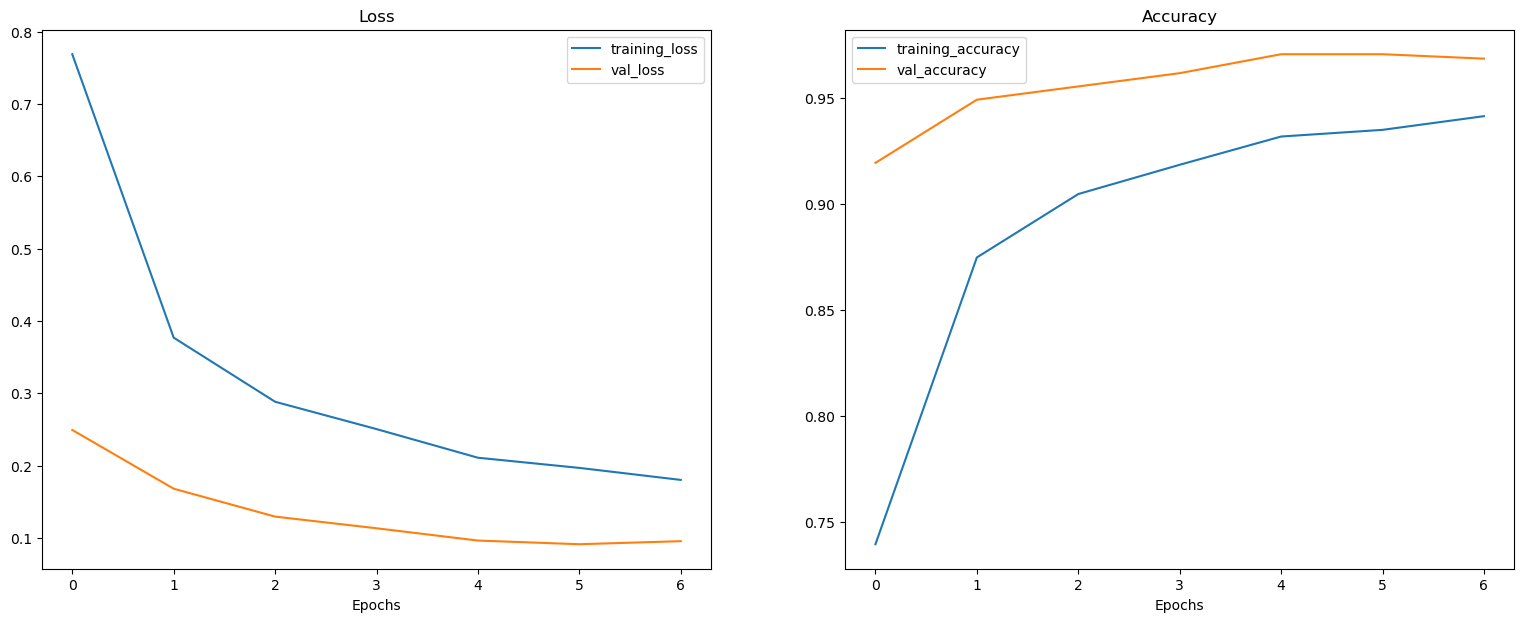

In [35]:
# 4. Plot model training performance
plot_loss_curves(history_model_4)

In [36]:
# 5. Loading the best weights
best_weights_path_model_4 = "/kaggle/working/models/model_4_effnetb7_ft.h5"
# model_4 = models.load_model(best_weights_path_model_4)

In [37]:
# 6. Evaluate on test data
model_4.evaluate(val_ds)

105/105 [==============================] - 50s 478ms/step - loss: 0.1023 - accuracy: 0.9669


[0.1023012325167656, 0.9669446349143982]

105/105 [==============================] - 53s 477ms/step


{'Accuracy': 0.9657534246575342,
 'Precision': 0.9657534246575342,
 'Recall': 0.9657534246575342,
 'F1-score': 0.9657534246575342,
 'Size (MB)': 0}

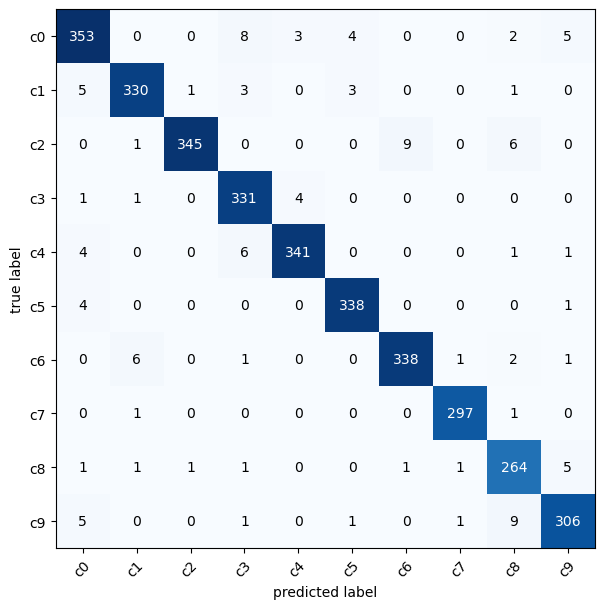

In [38]:
# 7. Get the model's performance metrics
model_4_pred_probs = model_4.predict(val_ds, verbose=1)
model_4_pred_classes = model_4_pred_probs.argmax(axis=1).reshape(-1).astype("int")

model_4_metrics = get_metrics(
    y_true=model_4_pred_classes,
    y_pred=y_val_labels,
    model_path=pathlib.Path(''),
    plot_confusion_matrix=True,
    classes=CONFIG.classes,
)
model_4_metrics

In [44]:
#Recall per class
recall_per_class2 = []
for i in range(10):
    recall2 = recall_score(y_val_labels, model_4_pred_classes, labels=[i], average='weighted')

    recall_per_class2.append(recall2)

# Print recall for each class
for i, recall2 in enumerate(recall_per_class2):
    print(f"Recall for class {i}: {recall2}")

Recall for class 0: 0.9463806970509383
Recall for class 1: 0.9705882352941176
Recall for class 2: 0.9942363112391931
Recall for class 3: 0.9430199430199431
Recall for class 4: 0.9798850574712644
Recall for class 5: 0.976878612716763
Recall for class 6: 0.9712643678160919
Recall for class 7: 0.99
Recall for class 8: 0.9230769230769231
Recall for class 9: 0.9592476489028213


### Model 5
***Architecture***:  Custom Sequential Model       
***Optimizer***: Adam optimizer with 0.001 learning rate  
***Epochs*** : 10                             
***Callbacks*** : Early stopping, Model checkpointing  

In [43]:
# 0. Set random seed
tf.random.set_seed(CONFIG.seed)
INPUT_SHAPE = (CONFIG.image_size, CONFIG.image_size, 3)

model_5 =  tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
],name="model_5_custom_ft",
)

# 2. Compile the model
LEARNING_RATE = 1e-3
optim = optimizers.Adam(learning_rate=LEARNING_RATE)
model_5.compile(
    loss="sparse_categorical_crossentropy", optimizer=optim, metrics=["accuracy"]
)

# 3. Fit the model
history_model_5 = model_5.fit(
    train_ds,
    epochs=7,
    validation_data=val_ds,
    verbose=CONFIG.verbose,
)

Epoch 1/7
596/596 [==============================] - 343s 571ms/step - loss: 2.7365 - accuracy: 0.3292 - val_loss: 1.2699 - val_accuracy: 0.5649
Epoch 2/7
596/596 [==============================] - 328s 550ms/step - loss: 1.0329 - accuracy: 0.6558 - val_loss: 0.7075 - val_accuracy: 0.7787
Epoch 3/7
596/596 [==============================] - 335s 562ms/step - loss: 0.7454 - accuracy: 0.7512 - val_loss: 0.5126 - val_accuracy: 0.8443
Epoch 4/7
596/596 [==============================] - 337s 565ms/step - loss: 0.6050 - accuracy: 0.8029 - val_loss: 0.4161 - val_accuracy: 0.8734
Epoch 5/7
596/596 [==============================] - 340s 570ms/step - loss: 0.5153 - accuracy: 0.8315 - val_loss: 0.3152 - val_accuracy: 0.9023
Epoch 6/7
596/596 [==============================] - 335s 563ms/step - loss: 0.4439 - accuracy: 0.8570 - val_loss: 0.2781 - val_accuracy: 0.9166
Epoch 7/7
596/596 [==============================] - 329s 551ms/step - loss: 0.4065 - accuracy: 0.8702 - val_loss: 0.3289 - val_ac

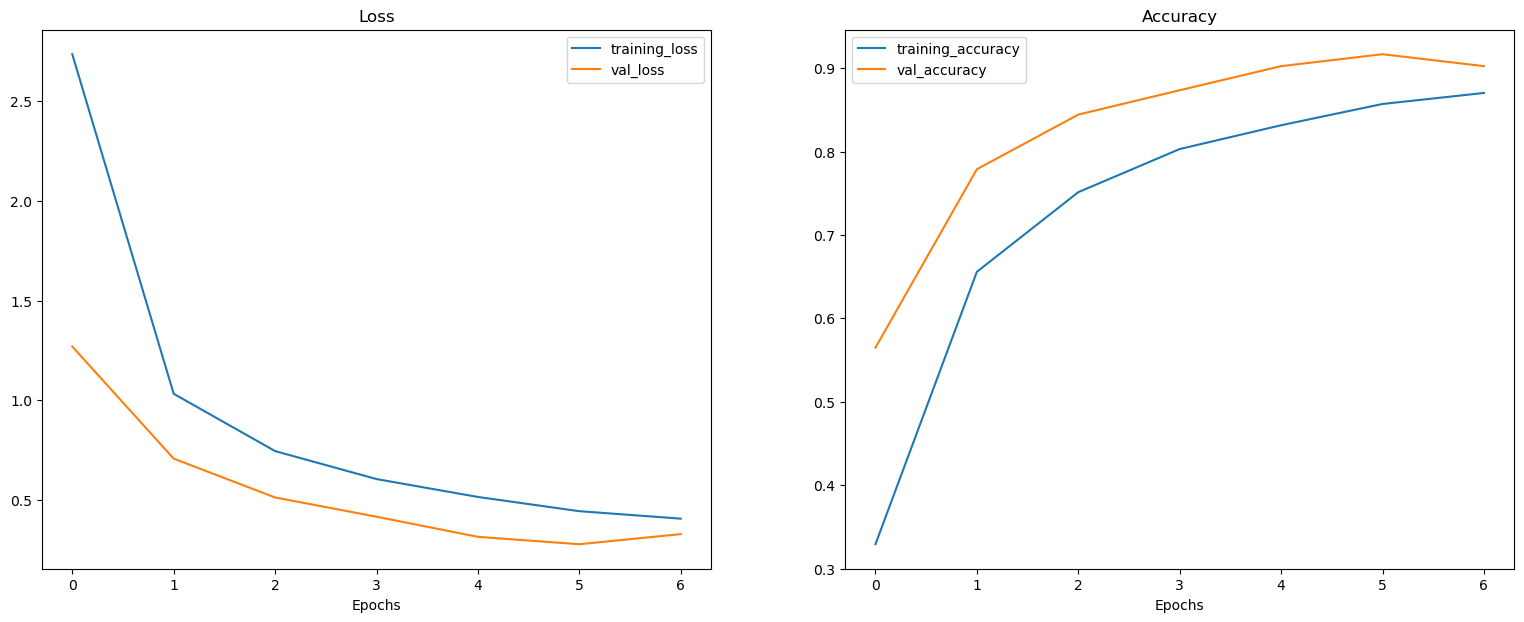

In [45]:
# 4. Plot model training performance
plot_loss_curves(history_model_5)

In [46]:
# 5. Loading the best weights
best_weights_path_model_5 = "/kaggle/working/models/model_5_custom_ft.h5"


In [47]:
# 6. Evaluate on test data
model_5.evaluate(val_ds)

105/105 [==============================] - 49s 463ms/step - loss: 0.3243 - accuracy: 0.9008


[0.3243339955806732, 0.9008338451385498]

105/105 [==============================] - 48s 458ms/step


{'Accuracy': 0.9017272185824896,
 'Precision': 0.9017272185824896,
 'Recall': 0.9017272185824896,
 'F1-score': 0.9017272185824896,
 'Size (MB)': 0}

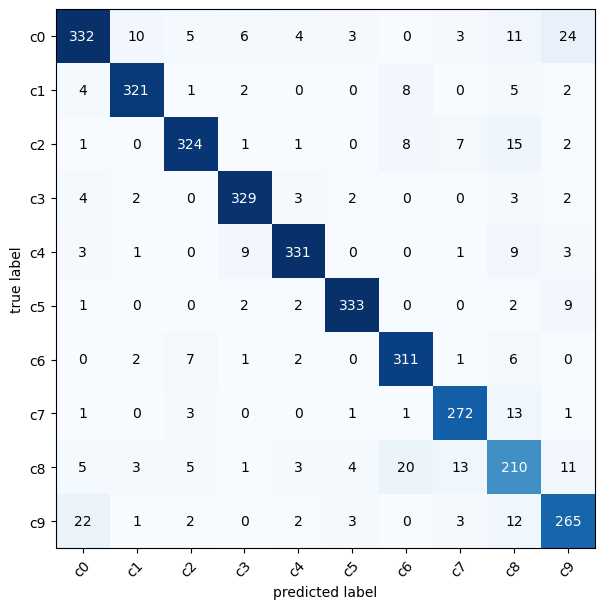

In [48]:
# 7. Get the model's performance metrics
model_5_pred_probs = model_5.predict(val_ds, verbose=1)
model_5_pred_classes = model_5_pred_probs.argmax(axis=1).reshape(-1).astype("int")

model_5_metrics = get_metrics(
    y_true=model_5_pred_classes,
    y_pred=y_val_labels,
    model_path=pathlib.Path(''),
    plot_confusion_matrix=True,
    classes=CONFIG.classes,
)
model_5_metrics

In [49]:
#Recall per class
recall_per_class2 = []
for i in range(10):
    recall2 = recall_score(y_val_labels, model_5_pred_classes, labels=[i], average='weighted')

    recall_per_class2.append(recall2)

# Print recall for each class
for i, recall2 in enumerate(recall_per_class2):
    print(f"Recall for class {i}: {recall2}")

Recall for class 0: 0.8900804289544236
Recall for class 1: 0.9441176470588235
Recall for class 2: 0.9337175792507204
Recall for class 3: 0.9373219373219374
Recall for class 4: 0.9511494252873564
Recall for class 5: 0.9624277456647399
Recall for class 6: 0.8936781609195402
Recall for class 7: 0.9066666666666666
Recall for class 8: 0.7342657342657343
Recall for class 9: 0.8307210031347962


# Overall Models' Comparison

In [52]:
# Dataframe of results-
results_df = pd.DataFrame({model_1.name: model_1_metrics,
                           model_2.name: model_2_metrics,
                           model_3.name: model_3_metrics,
                           model_4.name: model_4_metrics,
                           model_5.name: model_5_metrics}).T

results_df["Size (MB)"] = results_df["Size (MB)"] / results_df["Size (MB)"].max()
results_df

,Accuracy,Precision,Recall,F1-score,Size (MB)
model_1_resnet_ft,0.925849,0.925849,0.925849,0.925849,1.000000
model_2_vgg_ft,0.903812,0.903812,0.903812,0.903812,0.555556
model_3_vgg_ft,0.896665,0.896665,0.896665,0.896665,0.982906
model_4_effnetb7_ft,0.965753,0.965753,0.965753,0.965753,0.000000
model_5_custom_ft,0.901727,0.901727,0.901727,0.901727,0.000000


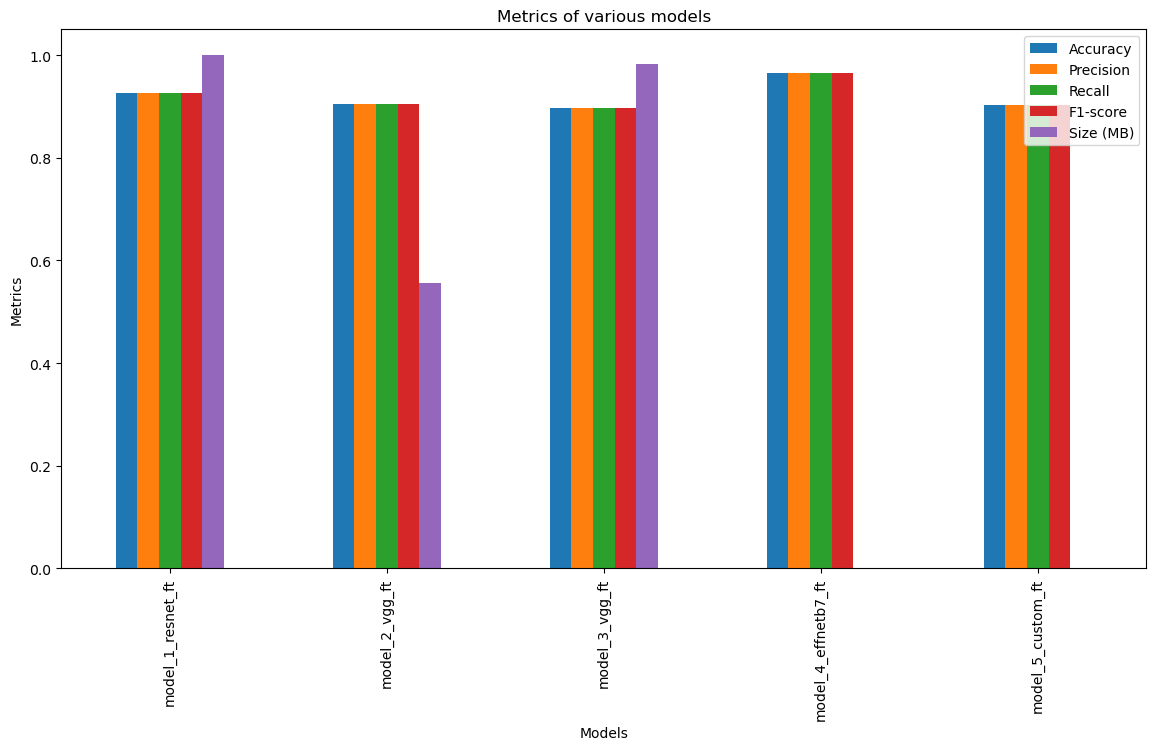

In [53]:
results_df[["Accuracy", "Precision", "Recall", "F1-score", "Size (MB)"]].plot(kind="bar", figsize=(14,7), title="Metrics of various models", ylabel="Metrics", xlabel="Models");